In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Importing Packages**




In [5]:
import pandas as pd
import numpy as np

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GRU, Bidirectional, Dropout
from keras.utils import plot_model

import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import math
import warnings
warnings.filterwarnings("ignore")
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error

### *Initializing Window size*

In [14]:
window_size = 10

# **Functions**

In [36]:
def read_label():
    label = {}
    for i in range(1,7):
        hi = '/content/gdrive/MyDrive/energy_disaggregation/windowGRU/data/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label


#-------------------------------------------------------------------------------------------------------------------

def read_merge_data(house):
    path = '/content/gdrive/MyDrive/energy_disaggregation/windowGRU/data/house_{}/'.format(house)
    
    
    file = path + 'channel_1.dat'

    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 

    num_apps = len(glob.glob(path + 'channel*'))

    
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df

#-------------------------------------------------------------------------------------------------------------------

def uniform_label(df):
  if 'kitchen_outlets_7' in df.columns:   
    df = df.rename(columns={'kitchen_outlets_7': 'kitchen'})

  if 'kitchen_outlets_5' in df.columns:
    df = df.rename(columns={'kitchen_outlets_5': 'kitchen'})

  if 'kitchen_outlets_3' in df.columns:
    df = df.rename(columns={'kitchen_outlets_3': 'kitchen'})

  if 'kitchen_outlets_24' in df.columns:
    df = df.rename(columns={'kitchen_outlets_24': 'kitchen'})

    

  return df

#----------------------------------------------------------------------------------------------------------------------

def add_houses(df_list, appliance):
  merged_df = pd.DataFrame()
  for df in df_list:
    df = uniform_label(df)

    df["aggregate_mains"] = df['mains_1'] + df['mains_2']
    df = df[['aggregate_mains',appliance]]
    
    merged_df = pd.concat([merged_df,df])
  return merged_df

#-----------------------------------------------------------------------------------------------------------------------

def max_value(df):
  return max(df['aggregate_mains'])


#-----------------------------------------------------------------------------------------------------------------------


def preprocess_data(df, appliance, nmax):

  df['aggregate_mains'] = df['aggregate_mains']/ nmax

  df[appliance] = df[appliance]/ nmax
  
  return df

#----------------------------------------------------------------------------------------------------------------------
def create_window_chunk(df, sequence_length):
  result = []
  for index in range(len(df) - sequence_length):
      result.append(df[index: index + sequence_length])

  return result

#----------------------------------------------------------------------------------------------------------------------

def _create_model(window_size):
    '''Creates the GRU architecture described in the paper
    '''
    model = Sequential()

    # 1D Conv
    model.add(Conv1D(16, 4, activation='relu', input_shape=(window_size,1), padding="same", strides=1))

    #Bi-directional GRUs
    model.add(Bidirectional(GRU(64, activation='relu', return_sequences=True), merge_mode='concat'))
    model.add(Dropout(0.5))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False), merge_mode='concat'))
    model.add(Dropout(0.5))

    # Fully Connected Layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    print(model.summary())

    return model

#---------------------------------------------------------------------------------------------------------------------







# **Data Preprocessing**

In [16]:
df_dic = {}
dates = {}

### *Reading and storing labels of all the houses in a dictionary*

In [17]:
labels = read_label()
labels

{1: {1: 'mains_1',
  2: 'mains_2',
  3: 'oven_3',
  4: 'oven_4',
  5: 'refrigerator_5',
  6: 'dishwaser_6',
  7: 'kitchen_outlets_7',
  8: 'kitchen_outlets_8',
  9: 'lighting_9',
  10: 'washer_dryer_10',
  11: 'microwave_11',
  12: 'bathroom_gfi_12',
  13: 'electric_heat_13',
  14: 'stove_14',
  15: 'kitchen_outlets_15',
  16: 'kitchen_outlets_16',
  17: 'lighting_17',
  18: 'lighting_18',
  19: 'washer_dryer_19',
  20: 'washer_dryer_20'},
 2: {1: 'mains_1',
  2: 'mains_2',
  3: 'kitchen_outlets_3',
  4: 'lighting_4',
  5: 'stove_5',
  6: 'microwave_6',
  7: 'washer_dryer_7',
  8: 'kitchen_outlets_8',
  9: 'refrigerator_9',
  10: 'dishwaser_10',
  11: 'disposal_11'},
 3: {1: 'mains_1',
  2: 'mains_2',
  3: 'outlets_unknown_3',
  4: 'outlets_unknown_4',
  5: 'lighting_5',
  6: 'electronics_6',
  7: 'refrigerator_7',
  8: 'disposal_8',
  9: 'dishwaser_9',
  10: 'furance_10',
  11: 'lighting_11',
  12: 'outlets_unknown_12',
  13: 'washer_dryer_13',
  14: 'washer_dryer_14',
  15: 'lighting

### *Converting raw dataset of a house into Pandas Dataframe and storing all the dataframes in a dictionary*

In [18]:
for i in range(1,7):
    df_dic[i] = read_merge_data(i)
    
print(df_dic)

{1:                      mains_1  mains_2  ...  washer_dryer_19  washer_dryer_20
2011-04-18 13:22:13   222.20   118.83  ...              0.0              0.0
2011-04-18 13:22:16   223.17   119.19  ...              0.0              0.0
2011-04-18 13:22:20   223.60   118.92  ...              0.0              0.0
2011-04-18 13:22:23   222.91   119.16  ...              0.0              0.0
2011-04-18 13:22:26   222.94   118.83  ...              0.0              0.0
...                      ...      ...  ...              ...              ...
2011-05-24 19:56:20   235.73    38.65  ...              0.0              0.0
2011-05-24 19:56:23   235.03    38.66  ...              0.0              0.0
2011-05-24 19:56:27   235.46    38.61  ...              0.0              0.0
2011-05-24 19:56:30   235.98    38.77  ...              0.0              0.0
2011-05-24 19:56:34   235.29    38.83  ...              0.0              0.0

[406748 rows x 20 columns], 2:                      mains_1  mains_2  .

### *Checking the Number of days of available data of different houses*

In [19]:
for i in range(1,7):
    dates[i] = [str(time)[:10] for time in df_dic[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

House 3 data contain 26 days from 2011-04-16 to 2011-05-31.
['2011-04-16', '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-21', '2011-05-22', '2011-05-23', '

In [20]:
for i in range(1,7):
    print('House {} data has shape: '.format(i), df_dic[i].shape)
    display(df_dic[i].tail(3))

House 1 data has shape:  (406748, 20)


,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-05-24 19:56:27,235.46,38.61,0.0,0.0,190.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:30,235.98,38.77,0.0,0.0,189.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:34,235.29,38.83,0.0,0.0,186.0,0.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


House 2 data has shape:  (316840, 11)


,mains_1,mains_2,kitchen_outlets_3,lighting_4,stove_5,microwave_6,washer_dryer_7,kitchen_outlets_8,refrigerator_9,dishwaser_10,disposal_11
2011-05-22 23:59:01,10.84,252.61,0.0,9.0,0.0,5.0,0.0,2.0,158.0,0.0,0.0
2011-05-22 23:59:04,10.88,253.02,0.0,9.0,0.0,4.0,0.0,2.0,160.0,0.0,0.0
2011-05-22 23:59:08,10.84,252.77,0.0,9.0,0.0,4.0,0.0,2.0,157.0,0.0,0.0


House 3 data has shape:  (376150, 22)


,mains_1,mains_2,outlets_unknown_3,outlets_unknown_4,lighting_5,electronics_6,refrigerator_7,disposal_8,dishwaser_9,furance_10,lighting_11,outlets_unknown_12,washer_dryer_13,washer_dryer_14,lighting_15,microwave_16,lighting_17,smoke_alarms_18,lighting_19,bathroom_gfi_20,kitchen_outlets_21,kitchen_outlets_22
2011-05-31 00:19:30,15.45,2.23,0.0,1.0,1.0,1139.0,8.0,6.0,3.0,7.0,147.0,0.0,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:33,15.42,2.23,0.0,1.0,1.0,1138.0,8.0,6.0,3.0,7.0,147.0,0.0,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:36,15.44,2.23,0.0,1.0,1.0,1134.0,7.0,6.0,3.0,7.0,147.0,0.0,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5


House 4 data has shape:  (428076, 20)


,mains_1,mains_2,lighting_3,furance_4,kitchen_outlets_5,outlets_unknown_6,washer_dryer_7,stove_8,air_conditioning_9,air_conditioning_10,miscellaeneous_11,smoke_alarms_12,lighting_13,kitchen_outlets_14,dishwaser_15,bathroom_gfi_16,bathroom_gfi_17,lighting_18,lighting_19,air_conditioning_20
2011-06-04 00:45:31,403.36,94.65,173.0,27.0,38.0,3.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:35,401.11,94.63,174.0,27.0,34.0,4.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:38,400.24,94.43,175.0,27.0,38.0,4.0,1.0,5.0,0.0,0.0,2.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0


House 5 data has shape:  (77451, 26)


,mains_1,mains_2,microwave_3,lighting_4,outlets_unknown_5,furance_6,outlets_unknown_7,washer_dryer_8,washer_dryer_9,subpanel_10,subpanel_11,electric_heat_12,electric_heat_13,lighting_14,outlets_unknown_15,bathroom_gfi_16,lighting_17,refrigerator_18,lighting_19,dishwaser_20,disposal_21,electronics_22,lighting_23,kitchen_outlets_24,kitchen_outlets_25,outdoor_outlets_26
2011-06-01 00:20:07,151.68,37.39,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,5.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,5.0,115.0,0.0,0.0,0.0
2011-06-01 00:20:10,150.42,37.21,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,5.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,5.0,100.0,0.0,0.0,0.0
2011-06-01 00:20:14,149.29,37.10,3.0,0.0,3.0,7.0,0.0,0.0,0.0,12.5,5.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,5.0,97.5,0.0,0.0,0.0


House 6 data has shape:  (192192, 17)


,mains_1,mains_2,kitchen_outlets_3,washer_dryer_4,stove_5,electronics_6,bathroom_gfi_7,refrigerator_8,dishwaser_9,outlets_unknown_10,outlets_unknown_11,electric_heat_12,kitchen_outlets_13,lighting_14,air_conditioning_15,air_conditioning_16,air_conditioning_17
2011-06-14 01:12:25,19.82,401.65,4.0,3.0,1.0,0.0,4.0,140.0,0.0,87.0,0.0,7.0,1.0,114.0,4.0,0.0,0.0
2011-06-14 01:12:33,19.59,400.11,4.0,3.0,1.0,0.0,3.0,143.0,0.0,87.0,0.0,7.0,1.0,113.0,4.0,0.0,0.0
2011-06-14 01:12:36,19.59,399.47,4.0,3.0,1.0,0.0,3.0,143.0,0.0,87.0,0.0,7.0,0.0,113.0,4.0,0.0,0.0


### *Preparing training data - house 1 & 4, Appliance- Kitchen_outlet*

In [21]:
df_list = [df_dic[1], df_dic[4]]
dfs = add_houses(df_list, 'kitchen')

In [22]:
dfs

,aggregate_mains,kitchen
2011-04-18 13:22:13,341.03,34.0
2011-04-18 13:22:16,342.36,34.0
2011-04-18 13:22:20,342.52,34.0
2011-04-18 13:22:23,342.07,35.0
2011-04-18 13:22:26,341.77,34.0
...,...,...
2011-06-04 00:45:25,495.75,34.0
2011-06-04 00:45:28,494.00,36.0
2011-06-04 00:45:31,498.01,38.0
2011-06-04 00:45:35,495.74,34.0


### *Creating window chunk and normalizing dataframe*

In [23]:
 nmax = max_value(dfs)

In [24]:
df = preprocess_data(dfs, 'kitchen', nmax)

df

,aggregate_mains,kitchen
2011-04-18 13:22:13,0.028594,0.002851
2011-04-18 13:22:16,0.028706,0.002851
2011-04-18 13:22:20,0.028719,0.002851
2011-04-18 13:22:23,0.028681,0.002935
2011-04-18 13:22:26,0.028656,0.002851
...,...,...
2011-06-04 00:45:25,0.041567,0.002851
2011-06-04 00:45:28,0.041420,0.003018
2011-06-04 00:45:31,0.041756,0.003186
2011-06-04 00:45:35,0.041566,0.002851


In [25]:
sequence_length = window_size


x = create_window_chunk(df['aggregate_mains'], sequence_length)

y = df['kitchen'][sequence_length:]

In [26]:
x = np.array(x)
y = np.array(y)

### *reshaping the data*

In [29]:
x_train = np.reshape(x, (x.shape[0], x.shape[1], 1))

# **Creating Model**

In [31]:
model = _create_model(window_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 16)            80        
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 128)           31488     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               198144    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

###*training model*

In [32]:
start = time.time()
model.fit(x_train, y, epochs=2, batch_size=128, shuffle=True, validation_split=0.33)
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/2
4370/4370 [==============================] - 392s 82ms/step - loss: 9.9237e-07 - val_loss: 4.6604e-06
Epoch 2/2
4370/4370 [==============================] - 360s 82ms/step - loss: 6.3970e-07 - val_loss: 5.2425e-06
Finish trainning. Time:  751.3553023338318


###*Saving the trained model*

In [33]:
model.save("gdrive/MyDrive/saved_model/kitchen_outlet_train_1_4_test_5_6_epochs_2_batch_128_window_10_validation_split_0.33_model.h5")

### *Preparing and preprocessing test data - house 5 & 6*

In [38]:
df_list = [df_dic[5],df_dic[6]]
dfs = add_houses(df_list, 'kitchen')
df_test = preprocess_data(dfs, "kitchen", nmax)

print(df_test.head())

                     aggregate_mains  kitchen
2011-04-18 04:24:07         0.026208      0.0
2011-04-18 04:24:11         0.026298      0.0
2011-04-18 04:24:14         0.026215      0.0
2011-04-18 04:24:18         0.026114      0.0
2011-04-18 04:24:21         0.026201      0.0


In [39]:
sequence_length = window_size

x_test = create_window_chunk(df_test['aggregate_mains'], sequence_length)

y_test = df_test['kitchen'][sequence_length:]


In [40]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [43]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

###*Predicting on the test*

In [44]:
pred_test = model.predict(x_test, batch_size=128)

In [45]:

pred_test = np.reshape(pred_test, (len(pred_test)))


### *Denormalized the test and predicted data*

In [47]:
y_test_d = y_test * nmax
y_pred_d = pred_test* nmax

#**Data Visualization**

<function matplotlib.pyplot.show>

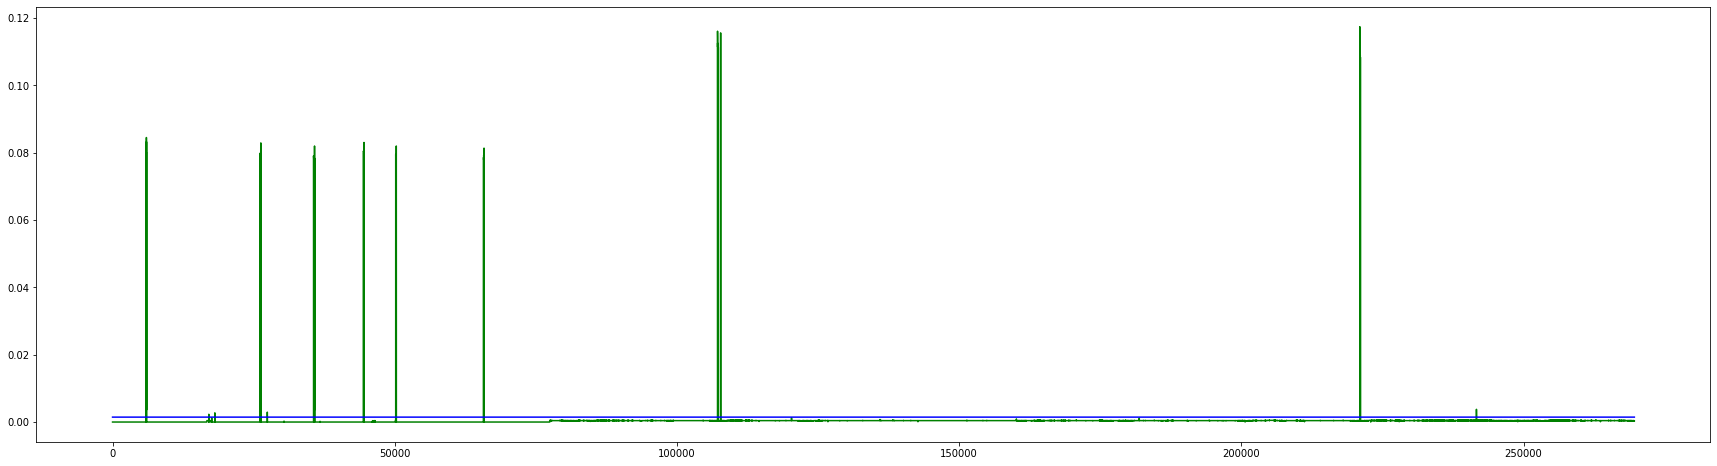

In [49]:
plt.figure(figsize = (30, 8))
plt.plot(y_test, color='green', label="ground kitchen outlet")
plt.plot(pred_test, color='blue', label="predicted kitchen outlet")

plt.legend
plt.show

###*More Zooming into the graph*


<function matplotlib.pyplot.show>

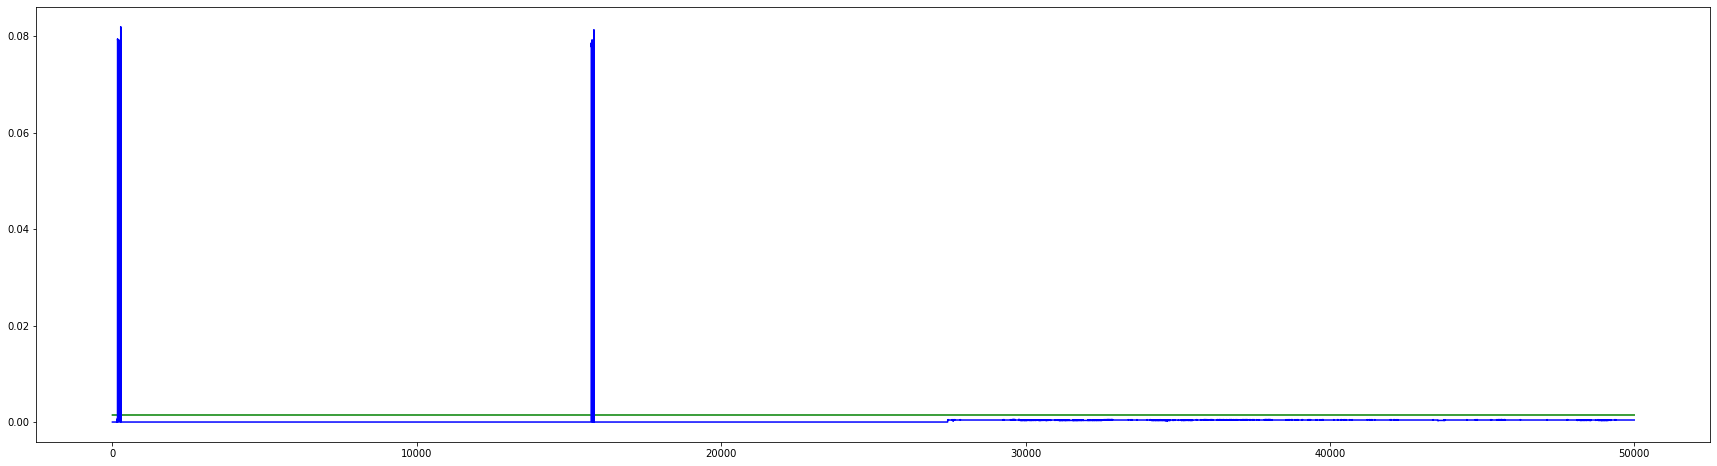

In [52]:
plt.figure(figsize = (30, 8))
plt.plot(pred_test[50000:100000], color='green', label="predicted kitchen outlet")
plt.plot(y_test[50000:100000], color='blue', label="ground kitchen outlet")

plt.legend
plt.show

#**Evaluation Metrics**

In [50]:
# Calculating MAE on test data
mean_absolute_error(y_test_d, y_pred_d)

15.976928011367184

In [51]:
# Calculating RMSE on test data
math.sqrt(mean_squared_error(y_test_d, y_pred_d))

48.869227024427566